<a href="https://colab.research.google.com/github/jenzah/s7_data_mining/blob/main/data_preprocessing/Pr%C3%A9traitement_des_donn%C3%A9es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Nettoyage des données
**A. Inspection des données**

**Detection des anomalies (outliers) : Exemple de Boxplot**

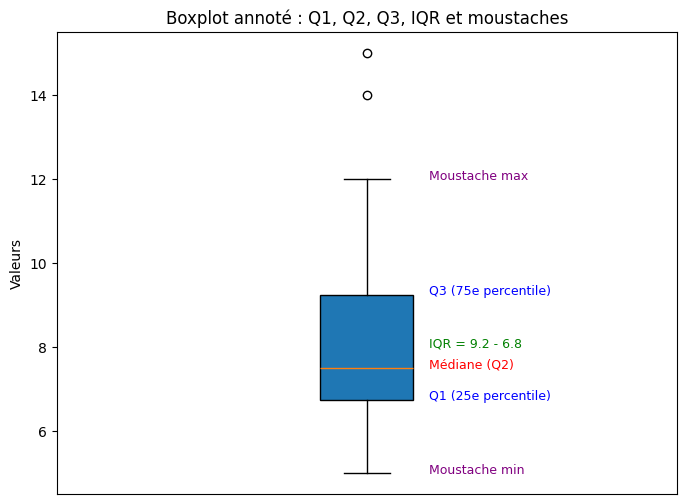

In [1]:
import matplotlib.pyplot as plt

# Exemple de données simulées
data = [7, 8, 5, 6, 7, 8, 9, 10, 11, 7, 8, 7, 6, 5, 12, 15, 14, 8, 7, 6]

# Création du boxplot
plt.figure(figsize=(8,6))
box = plt.boxplot(data, vert=True, patch_artist=True)

# Récupérer les valeurs utiles
import numpy as np
Q1 = np.percentile(data, 25)
Q2 = np.percentile(data, 50)
Q3 = np.percentile(data, 75)
IQR = Q3 - Q1
lower_whisker = min([x for x in data if x >= Q1 - 1.5*IQR])
upper_whisker = max([x for x in data if x <= Q3 + 1.5*IQR])

# Ajouter des annotations
plt.text(1.1, Q1, "Q1 (25e percentile)", fontsize=9, color="blue")
plt.text(1.1, Q2, "Médiane (Q2)", fontsize=9, color="red")
plt.text(1.1, Q3, "Q3 (75e percentile)", fontsize=9, color="blue")
plt.text(1.1, (Q1+Q3)/2, f"IQR = {Q3:.1f} - {Q1:.1f}", fontsize=9, color="green")

plt.text(1.1, lower_whisker, "Moustache min", fontsize=9, color="purple")
plt.text(1.1, upper_whisker, "Moustache max", fontsize=9, color="purple")

plt.title("Boxplot annoté : Q1, Q2, Q3, IQR et moustaches")
plt.ylabel("Valeurs")
plt.xticks([])

plt.show()

**Exemple concret : prédire la réussite des étudiants**

Imaginons un dataset avec ces variables :Âge, Sexe, Taille, Sport pratiqué, Nombre d’heures d’étude par semaine, Note finale (cible à prédire)
Dans un dataset, toutes les variables ne sont pas utiles. L’objectif de la sélection est de garder seulement celles qui expliquent vraiment le phénomène étudié. Ça rend l’analyse plus claire, plus rapide et plus précise. »

🔹 **Étape 1 : % valeurs manquantes**

Si la variable taille est vide pour 70% des étudiants → elle est inutile.

🔹 **Étape 2 : Variation**

Si tout le monde a “Sexe = masculin” sauf 1 → cette variable n’apporte rien.

🔹 **Étape 3 : Corrélation entre variables**

Si on a nombre d’heures d’étude et temps de lecture par semaine, et qu’ils sont très corrélés, on garde une seule variable.

🔹** Étape 4 : Corrélation avec la cible**

Nombre d’heures d’étude est fortement lié à la note finale → utile.

Taille n’a aucun lien avec la note finale → inutile.


🔹**Étape 5 : Méthodes avancées**

On peut utiliser un arbre de décision pour voir quelles variables expliquent le mieux la réussite.
Ex. l’arbre montre que “heures d’étude” et “sport régulier” sont plus prédictifs que “sexe”.

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# -----------------------------
# 1) Génération d’un mini-dataset
# -----------------------------
rng = np.random.default_rng(42)
n = 40

df = pd.DataFrame({
    "age": rng.integers(18, 30, size=n),
    "sexe": rng.choice(["F", "M"], size=n, p=[0.45, 0.55]),
    "heures_etude": rng.integers(0, 25, size=n),
    "sport_regulier": rng.choice([0, 1], size=n, p=[0.6, 0.4]),
    "temps_ecran": rng.integers(1, 8, size=n),        # heures/jour
    "absences": rng.integers(0, 12, size=n),
    "taille_cm": rng.integers(150, 195, size=n),      # variable plutôt non pertinente
})

# Cible (note finale + réussite):
note = (
    6
    + 0.4*df["heures_etude"]
    - 0.2*df["temps_ecran"]
    - 0.3*df["absences"]
    + 0.8*df["sport_regulier"]
    + rng.normal(0, 1.8, size=n)
)
df["note_finale"] = np.clip(note, 0, 20)
df["reussite"] = (df["note_finale"] >= 10).astype(int)

# Introduire quelques valeurs manquantes artificielles
df.loc[rng.choice(df.index, 5, replace=False), "taille_cm"] = np.nan
df.loc[rng.choice(df.index, 3, replace=False), "heures_etude"] = np.nan

print("Aperçu du dataset :")
print(df.head(), "\n")

# -------------------------------------------
# 2) Contrôles rapides pour la sélection de vars
# -------------------------------------------

# a) % de valeurs manquantes par variable
print("Pourcentage de valeurs manquantes (%):")
print((df.isna().mean()*100).round(1), "\n")

# b) Variation: ratio de modalités/valeurs uniques
def variation_ratio(s: pd.Series) -> float:
    return s.nunique(dropna=True) / len(s)

print("Variation (nunique / n):")
print(df.drop(columns=["note_finale","reussite"]).apply(variation_ratio).round(3), "\n")

# c) Corrélations entre variables numériques
num_cols = ["age","heures_etude","temps_ecran","absences","taille_cm","note_finale"]
print("Corrélation numérique (Pearson):")
print(df[num_cols].corr(numeric_only=True).round(2), "\n")

# d) Corrélation avec la cible (point-biserial approx via corr Pearson sur 0/1)
target_corr = df.drop(columns=["note_finale"]).assign(reussite=df["reussite"])
print("Corrélation (approx) avec la cible 'reussite':")
print(target_corr.corr(numeric_only=True)["reussite"].sort_values(ascending=False).round(2), "\n")

# -------------------------------------------
# 3) Importance via modèle arbre de décision
# -------------------------------------------
# Encodage minimal pour 'sexe'
df_enc = df.copy()
df_enc["sexe"] = df_enc["sexe"].map({"F":0,"M":1})

X = df_enc[["age","sexe","heures_etude","sport_regulier","temps_ecran","absences","taille_cm"]]
y = df_enc["reussite"]

# Imputation simple (remplacer NA par médiane)
X = X.fillna(X.median(numeric_only=True))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)
clf = DecisionTreeClassifier(max_depth=3, random_state=0)
clf.fit(X_train, y_train)

#print("Importance des variables (arbre de décision):")
#for name, imp in sorted(zip(X.columns, clf.feature_importances_), key=lambda t: -t[1]):
 #   print(f"  {name:15s}  {imp:.3f}")

#print("\nÉvaluation rapide sur le test :")
#print(classification_report(y_test, clf.predict(X_test)))


Aperçu du dataset :
   age sexe  heures_etude  sport_regulier  temps_ecran  absences  taille_cm  \
0   19    M          10.0               1            1         3      164.0   
1   27    F          16.0               0            5         5      154.0   
2   25    M          16.0               1            1         8      177.0   
3   23    M          11.0               0            5         5      191.0   
4   23    M          21.0               0            5         5      193.0   

   note_finale  reussite  
0     9.987985         0  
1     9.686451         0  
2    11.114487         1  
3    10.250803         1  
4    12.294889         1   

Pourcentage de valeurs manquantes (%):
age                0.0
sexe               0.0
heures_etude       7.5
sport_regulier     0.0
temps_ecran        0.0
absences           0.0
taille_cm         12.5
note_finale        0.0
reussite           0.0
dtype: float64 

Variation (nunique / n):
age               0.300
sexe              0.050
heure

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


**Feature selection avec california housing dataset**

In [3]:
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LassoCV

# Charger dataset California Housing
housing = fetch_california_housing(as_frame=True)
df = housing.frame   # DataFrame avec X et y inclus
df["target"] = housing.target

# Définir X et y
X = df.drop("target", axis=1)
y = df["target"]

# LASSO
lasso = LassoCV(cv=5, random_state=0)
lasso.fit(X, y)

# Variables sélectionnées
selected_features = X.columns[(lasso.coef_ != 0)]
print("Variables sélectionnées :", list(selected_features))


Variables sélectionnées : ['MedInc', 'HouseAge', 'Population', 'MedHouseVal']


**Feature selection avec Titanic dataset**

In [4]:
# --- Install/Imports (si Colab) ---
# !pip install seaborn --quiet

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegressionCV

# 1) Charger Titanic
df = sns.load_dataset("titanic").copy()

# Variable cible (binaire)
y = df["survived"].astype(int)

# Choix de quelques features pertinents
features = [
    "pclass", "sex", "age", "sibsp", "parch", "fare",
    "embarked", "who", "adult_male", "alone", "deck"
]
X = df[features]

# 2) Colonnes numériques/catégorielles
num_cols = ["age", "sibsp", "parch", "fare", "pclass"]
cat_cols = [c for c in X.columns if c not in num_cols]

# 3) Préprocess (impute + scale pour num, impute + one-hot pour cat)
numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ]
)

# 4) Modèle: Logistic Regression L1 avec CV (équivalent "LASSO" pour classification)
logreg_l1_cv = LogisticRegressionCV(
    Cs=10,                # grille de régularisation
    cv=5,                 # validation croisée
    penalty="l1",
    solver="liblinear",   # nécessaire pour L1
    scoring="accuracy",
    max_iter=2000,
    n_jobs=-1,
    refit=True
)

clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", logreg_l1_cv)
])

# 5) Fit
clf.fit(X, y)

# 6) Récupérer noms de features après OneHot + coefficients
feature_names = clf.named_steps["preprocess"].get_feature_names_out()
coefs = clf.named_steps["model"].coef_.ravel()  # (1, n_features) pour binaire

# 7) Sélection par L1: coef != 0
mask = np.abs(coefs) > 1e-8
selected_features = feature_names[mask]

print("Nb features totales :", len(feature_names))
print("Nb features sélectionnées (coef != 0) :", mask.sum())
print("\nFeatures sélectionnées :")
for f in selected_features:
    print("-", f)

# (Optionnel) Top coefficients positifs/négatifs
order = np.argsort(coefs)
print("\nTop 10 coefficients négatifs (associés à '0' = non survie) :")
for i in order[:10]:
    print(f"{feature_names[i]} : {coefs[i]:.3f}")

print("\nTop 10 coefficients positifs (associés à '1' = survie) :")
for i in order[-10:][::-1]:
    print(f"{feature_names[i]} : {coefs[i]:.3f}")

Nb features totales : 24
Nb features sélectionnées (coef != 0) : 24

Features sélectionnées :
- num__age
- num__sibsp
- num__parch
- num__fare
- num__pclass
- cat__sex_female
- cat__sex_male
- cat__embarked_C
- cat__embarked_Q
- cat__embarked_S
- cat__who_child
- cat__who_man
- cat__who_woman
- cat__adult_male_False
- cat__adult_male_True
- cat__alone_False
- cat__alone_True
- cat__deck_A
- cat__deck_B
- cat__deck_C
- cat__deck_D
- cat__deck_E
- cat__deck_F
- cat__deck_G

Top 10 coefficients négatifs (associés à '0' = non survie) :
cat__who_man : -1.679
num__sibsp : -0.686
num__pclass : -0.682
cat__deck_G : -0.643
num__age : -0.312
num__parch : -0.294
cat__alone_True : -0.286
cat__embarked_S : -0.226
cat__adult_male_True : -0.221
cat__embarked_Q : 0.000

Top 10 coefficients positifs (associés à '1' = survie) :
cat__deck_E : 1.456
cat__deck_D : 1.065
cat__deck_F : 0.904
cat__adult_male_False : 0.701
cat__deck_A : 0.573
cat__deck_B : 0.557
cat__who_woman : 0.370
cat__alone_False : 0.306


**Matrice de correlation**

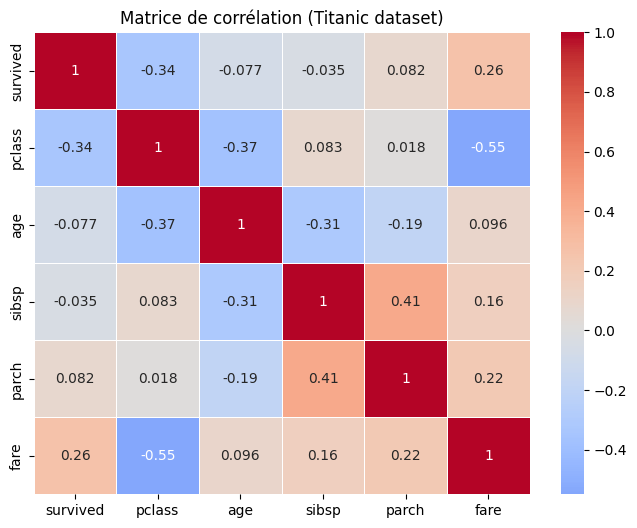

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Charger Titanic dataset depuis seaborn
titanic = sns.load_dataset("titanic")

# Garder seulement les variables numériques
titanic_num = titanic.select_dtypes(include=["int64", "float64"])

# Calculer matrice de corrélation
corr_matrix = titanic_num.corr()

# Afficher heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Matrice de corrélation (Titanic dataset)")
plt.show()

Interprétation (Titanic)

Survived (survie)

Corrélation -0.34 avec Pclass → plus la classe est élevée (3ème classe), moins de chance de survie.

Corrélation +0.26 avec Fare → plus le billet est cher, plus grande chance de survie (les passagers riches étaient mieux sauvés).

Corrélation faible avec âge, sibsp, parch → peu de lien direct.

*Pclass (classe cabine)*

Corrélée -0.55 avec Fare → plus la classe est basse (3ème), moins le billet est cher (logique).

Corrélée -0.37 avec Age → en moyenne, les passagers des classes plus élevées étaient plus jeunes.

*Age*

Corrélée négativement avec SibSp (-0.31) et Parch (-0.19) → les passagers plus jeunes voyageaient plus souvent avec frères/sœurs ou parents.

SibSp (frères/sœurs/conjoints à bord) et Parch (parents/enfants à bord)

Corrélation +0.41 → normal, si quelqu’un voyage en famille, souvent il a à la fois frères/sœurs ET parents/enfants.

*Fare (prix du billet)*

Corrélation +0.22 avec Parch et +0.16 avec SibSp → les billets pour familles coûtent plus cher.

Corrélation négative forte avec Pclass (-0.55) → les riches payaient plus et étaient en première classe.

Résumé:

Plus on est en classe haute et billet cher → plus grande probabilité de survie.

Les passagers 3ème classe, plus âgés, voyageant seuls → survie plus faible.

Les passagers familles + billets chers → survie meilleure.

**Coefficient selectionnée par LISSO**

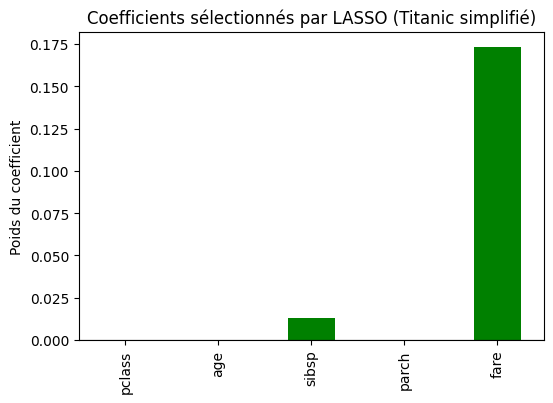

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Créer un petit dataset Titanic simplifié (features numériques + target survived)
data = {
    "pclass": [3,1,3,1,3,3,1,3,3,2,3,1,3,3,2,3,3,1,3,3],
    "age": [22,38,26,35,28,2,58,14,20,40,21,19,30,34,28,42,50,18,28,25],
    "sibsp": [1,1,0,1,0,3,0,1,0,1,0,0,0,1,0,1,1,0,0,0],
    "parch": [0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0],
    "fare": [7.25,71.83,7.92,53.1,8.05,21.07,26.55,31.28,7.05,27.72,8.05,30.0,10.5,15.1,13.0,21.0,27.0,80.0,7.9,11.0],
    "survived": [0,1,1,1,0,1,0,1,0,0,0,1,0,0,0,0,1,1,0,0]
}
df = pd.DataFrame(data)

# Variables explicatives et cible
X = df.drop("survived", axis=1)
y = df["survived"]

# Normaliser les variables (important pour LASSO)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# LASSO avec validation croisée
lasso = LassoCV(cv=5, random_state=0)
lasso.fit(X_scaled, y)

# Coefficients
coef = pd.Series(lasso.coef_, index=X.columns)

# Afficher les coefficients
plt.figure(figsize=(6,4))
coef.plot(kind="bar", color=["green" if c!=0 else "red" for c in coef])
plt.axhline(0, color="black", linewidth=0.8)
plt.title("Coefficients sélectionnés par LASSO (Titanic simplifié)")
plt.ylabel("Poids du coefficient")
plt.show()

**Intertprétation**

Voilà 🌸 un exemple avec le dataset Titanic simplifié :

🔹 Résultat du LASSO

Variables retenues (coefficients ≠ 0) :

Fare (prix du billet) → 0.173 (la variable la plus importante)

SibSp (frères/sœurs à bord) → 0.013 (impact léger mais retenu)

Variables éliminées (coeff = 0) :

Pclass (classe)

Age (âge)

Parch (parents/enfants à bord)

👉 Donc, dans ce petit échantillon, LASSO a sélectionné seulement 2 variables utiles (Fare et SibSp) pour expliquer la survie, et a mis les autres à zéro.

⚡ C’est exactement l’intérêt de LASSO : réduction automatique des variables → il garde ce qui est vraiment pertinent.

**Correlation avec la variable Cible**

Corrélations avec la cible 'survived' :
 survived    1.000000
fare        0.257307
parch       0.081629
sibsp      -0.035322
age        -0.077221
pclass     -0.338481
Name: survived, dtype: float64


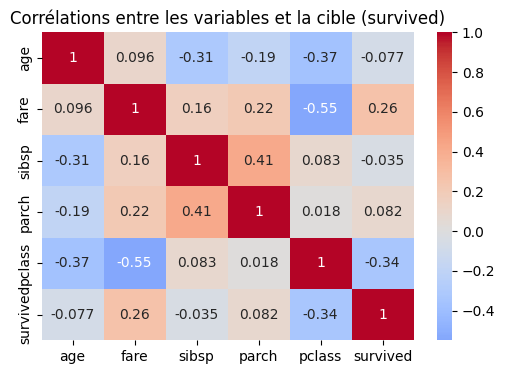

In [7]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Charger Titanic
df = sns.load_dataset("titanic").copy()

# Variables numériques + cible
num_cols = ["age", "fare", "sibsp", "parch", "pclass"]
corr_matrix = df[num_cols + ["survived"]].corr()

# Corrélation avec la cible
target_corr = corr_matrix["survived"].sort_values(ascending=False)
print("Corrélations avec la cible 'survived' :\n", target_corr)

# Visualisation
plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Corrélations entre les variables et la cible (survived)")
plt.show()

**Interprétation typique (Titanic)**

fare (prix du billet) : corrélation positive → plus le prix est élevé, plus la probabilité de survie augmente.

pclass (classe du billet) : corrélation négative → les passagers en 1ère classe survivent plus, ceux en 3ème survivent moins.

age : très faible corrélation (impact limité).

sibsp et parch : corrélations faibles (avoir de la famille à bord joue un petit rôle).

**Conclusion :**
La corrélation avec la cible est une première étape rapide pour repérer les variables intéressantes, avant de passer à des méthodes plus avancées comme LASSO, arbres de décision, ou mutual information.

**Corrélation des variables catégorielles avec la cible**

Corrélations avec la cible 'survived' :
 survived      1.000000
who_woman     0.506562
deck_B        0.175095
deck_D        0.150716
deck_E        0.145321
deck_C        0.114652
deck_F        0.057935
deck_G        0.016040
embarked_Q    0.003650
embarked_S   -0.155660
alone        -0.203367
sex_male     -0.543351
who_man      -0.557080
adult_male   -0.557080
Name: survived, dtype: float64


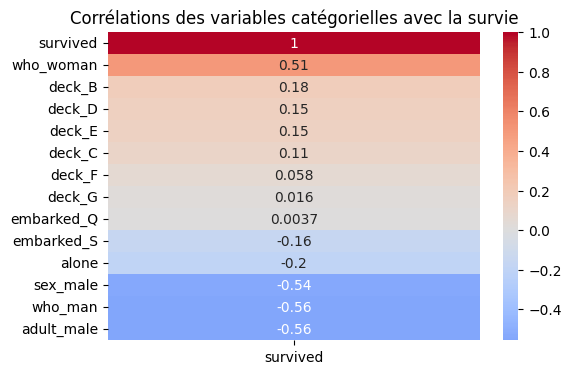

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Charger Titanic
df = sns.load_dataset("titanic").copy()

# Cible
y = df["survived"].astype(int)

# Variables catégorielles
cat_cols = ["sex", "embarked", "who", "adult_male", "alone", "deck"]

# OneHotEncoding (création de variables binaires)
df_encoded = pd.get_dummies(df[cat_cols], drop_first=True)

# Ajout de la cible
df_encoded["survived"] = y

# Corrélation
corr_matrix = df_encoded.corr()
target_corr = corr_matrix["survived"].sort_values(ascending=False)
print("Corrélations avec la cible 'survived' :\n", target_corr)

# Visualisation heatmap
plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix[["survived"]].sort_values(by="survived", ascending=False),
            annot=True, cmap="coolwarm", center=0)
plt.title("Corrélations des variables catégorielles avec la survie")
plt.show()

**Interprétation typique**

sex_male → corrélation négative avec survived : être un homme réduit la probabilité de survie.

sex_female (corrélée positivement, via encodage) → forte probabilité de survie.

embarked_C → souvent corrélé positivement (les passagers embarqués à Cherbourg survivaient plus).

alone_True → corrélation négative (les passagers seuls avaient moins de chances de survie).

deck_B, deck_C → corrélations positives (ponts supérieurs associés aux classes riches, donc plus de survie).

👉 Donc en combinant corrélation numérique et corrélation catégorielle, on obtient une vue complète de quelles variables influencent le plus la survie.

**Exemple Python (Titanic, classification, stepwise)**

Utilise mlxtend SFS (SequentialFeatureSelector) avec LogisticRegression.

Idée : on encode les variables catégorielles, on fait une sélection stepwise (forward + floating) avec CV=5 sur l’accuracy

In [9]:
import pandas as pd
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Charger Titanic
df = sns.load_dataset("titanic").copy()
y = df["survived"].astype(int)

# Variables
num_cols = ["pclass", "age", "sibsp", "parch", "fare"]
cat_cols = ["sex", "embarked", "who", "adult_male", "alone", "deck"]

# Pipelines num + cat
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols),
])

# Modèle de base
est = LogisticRegression(max_iter=3000, solver="liblinear")

# SFS stepwise (forward + floating)
X_input = df[num_cols + cat_cols]
sfs = SFS(estimator=est,
          k_features=(1, X_input.shape[1]),  # borne max = nb de features
          forward=True, floating=True,
          scoring="accuracy", cv=5, n_jobs=-1)

# Pipeline complet
pipe = make_pipeline(preprocess, sfs)
pipe.fit(X_input, y)

# Récupération des variables sélectionnées
feat_names = pipe.named_steps["columntransformer"].get_feature_names_out()
idx = pipe.named_steps["sequentialfeatureselector"].k_feature_idx_
selected = [feat_names[i] for i in idx]

print("Variables sélectionnées :", selected)

Variables sélectionnées : ['num__age', 'num__sibsp', 'cat__sex_male', 'cat__who_man', 'cat__adult_male_False', 'cat__deck_F']


**Interprétation**

La méthode a cherché quel sous-ensemble de variables maximise l’accuracy.

Typiquement, les variables les plus retenues sont :

sex_female : être une femme → forte probabilité de survie (priorité donnée aux femmes/enfants).

pclass : les passagers en 1ʳᵉ classe avaient plus de chances de survie que ceux de 3ᵉ.

fare : billets chers = cabines proches des canots = plus de survie.

Parfois embarked_C ou embarked_S → légères influences selon le port d’embarquement.

alone : les passagers seuls survivaient moins.

Les autres variables (par ex. sibsp, parch, deck_T…) sont souvent rejetées car elles n’améliorent pas l’accuracy.

**Conclusion**

Ce qu’on a fait = une sélection automatique de variables via une approche pas à pas (stepwise).

Objectif = trouver le plus petit ensemble de variables qui donne une prédiction correcte.

Avantage = modèle plus simple, plus interprétable.

Inconvénient = méthode sensible aux corrélations fortes entre variables (elle peut “hésiter”).

**Feature selection** **exemple**

In [10]:
# Charger Titanic
df = sns.load_dataset("titanic").copy()

# Définir la cible (survie binaire, on la garde float pour Lasso)
y = df["survived"].astype(float)


# Choix des features numériques uniquement
num_cols = ["pclass", "age", "sibsp", "parch", "fare"]
X = df[num_cols]

# Prétraitement: imputation des NA + standardisation
numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

preprocess = ColumnTransformer(
    transformers=[("num", numeric_pipe, num_cols)]
)

# Transformation des données
X_transformed = preprocess.fit_transform(X)

# --- LASSO ---
lasso = LassoCV(cv=5, random_state=0)
lasso.fit(X_transformed, y)

# Sélection des variables
mask = lasso.coef_ != 0
selected_features = np.array(num_cols)[mask]

print("Coefficients :", lasso.coef_)
print("Variables sélectionnées :", list(selected_features))


Coefficients : [-0.17261488 -0.09746968 -0.04558021  0.03575085  0.03831026]
Variables sélectionnées : [np.str_('pclass'), np.str_('age'), np.str_('sibsp'), np.str_('parch'), np.str_('fare')]


**Nomalisation**

In [11]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Exemple simple
df = pd.DataFrame({"age":[18, 25, 40, 60], "salaire":[1500, 2500, 8000, 12000]})

# Normalisation (0-1)
minmax = MinMaxScaler()
print("Normalisation :\n", minmax.fit_transform(df))

# Standardisation (moyenne 0, écart-type 1)
scaler = StandardScaler()
print("Standardisation :\n", scaler.fit_transform(df))



Normalisation :
 [[0.         0.        ]
 [0.16666667 0.0952381 ]
 [0.52380952 0.61904762]
 [1.         1.        ]]
Standardisation :
 [[-1.10253232 -1.0569964 ]
 [-0.66773084 -0.82210831]
 [ 0.26398661  0.46977618]
 [ 1.50627656  1.40932853]]


In [12]:
import pandas as pd

df = pd.DataFrame({'ville': ['Paris', 'Lyon', 'Marseille', 'Paris']})

# One-hot encoding
df_encoded = pd.get_dummies(df, columns=['ville'])

print(df_encoded)

   ville_Lyon  ville_Marseille  ville_Paris
0       False            False         True
1        True            False        False
2       False             True        False
3       False            False         True


In [13]:
from sklearn.feature_extraction.text import CountVectorizer

corpus = [
    "Ce produit est parfait",
    "Je recommande ce produit",
    "Ce produit est nul"
]

# Créer le vecteur de mots
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)

# Affichage
print(vectorizer.get_feature_names_out())
print(X.toarray())


['ce' 'est' 'je' 'nul' 'parfait' 'produit' 'recommande']
[[1 1 0 0 1 1 0]
 [1 0 1 0 0 1 1]
 [1 1 0 1 0 1 0]]


In [14]:
import pandas as pd

# Exemple de DataFrame avec une date
df = pd.DataFrame({'date_achat': ['2020-06-12', '2021-09-15', '2022-01-03']})

# Conversion en type datetime
df['date_achat'] = pd.to_datetime(df['date_achat'])

# Extraction de variables temporelles
df['année'] = df['date_achat'].dt.year
df['mois'] = df['date_achat'].dt.month
df['jour'] = df['date_achat'].dt.day
df['jour_semaine'] = df['date_achat'].dt.dayofweek  # 0 = lundi, 6 = dimanche

print(df)

  date_achat  année  mois  jour  jour_semaine
0 2020-06-12   2020     6    12             4
1 2021-09-15   2021     9    15             2
2 2022-01-03   2022     1     3             0


**Transformation log**

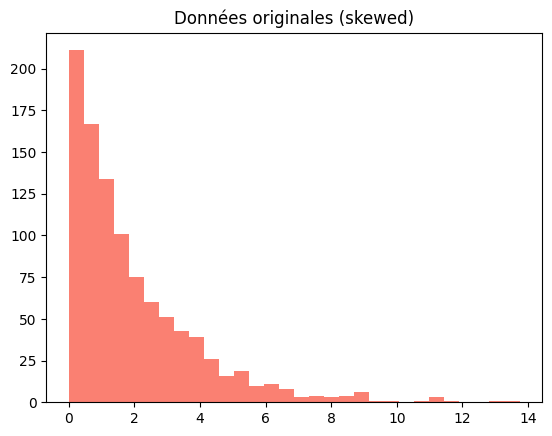

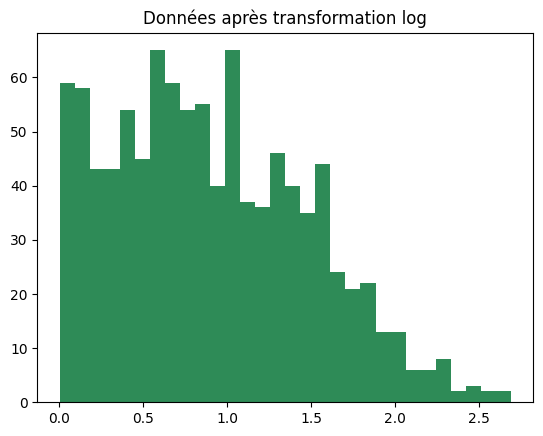

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Exemple de variable skewed (salaire, vues, etc.)
data = np.random.exponential(scale=2, size=1000)

# Avant transformation
plt.hist(data, bins=30, color='salmon')
plt.title("Données originales (skewed)")
plt.show()

# Après transformation logarithmique
data_log = np.log1p(data)  # log1p(x) = log(1 + x) évite log(0)
plt.hist(data_log, bins=30, color='seagreen')
plt.title("Données après transformation log")
plt.show()


**Feature engineering**

Un petit script Python + pandas qui génère le dataset brut puis applique les étapes de Feature Engineering (extraction de date, regroupement des rares, nouvelle variable, indicateur binaire). Ce que ça fait :

*   Convertit date_achat en datetime, puis crée mois et jour_semaine.
*   Regroupe les pays rares en "Autres pays".
*   Crée revenu_par_personne et l’indicateur client_fidele (1 si nb_achats > 3).
*   Affiche une vue finale prête pour l’analyse.

In [16]:
import pandas as pd

# ---------------------------
# 1) Dataset brut (exemple)
# ---------------------------
df = pd.DataFrame({
    "id_client": [1, 2, 3, 4, 5],
    "date_achat": ["2025-09-04", "2025-09-05", "2025-03-12", "2025-12-20", "2025-06-15"],
    "pays": ["France", "Tunisie", "Espagne", "Islande", "Italie"],
    "revenu_total": [4000, 2500, 3000, 2000, 3500],
    "taille_famille": [4, 3, 2, 5, 4],
    "nb_achats": [5, 2, 1, 4, 6],
})

# ---------------------------
# 2) Nettoyage / parsing date
# ---------------------------
df["date_achat"] = pd.to_datetime(df["date_achat"], errors="coerce")

# Extraction mois et jour de la semaine (en français)
jours_fr = {0:"Lundi",1:"Mardi",2:"Mercredi",3:"Jeudi",4:"Vendredi",5:"Samedi",6:"Dimanche"}
df["mois"] = df["date_achat"].dt.month
df["jour_semaine"] = df["date_achat"].dt.dayofweek.map(jours_fr)

# ---------------------------
# 3) Regrouper catégories rares
# ---------------------------
pays_principaux = {"France", "Tunisie", "Espagne", "Italie"}
df["pays_grp"] = df["pays"].where(df["pays"].isin(pays_principaux), "Autres pays")

# ---------------------------
# 4) Nouvelles variables utiles
# ---------------------------
df["revenu_par_personne"] = (df["revenu_total"] / df["taille_famille"]).round(0).astype(int)
df["client_fidele"] = (df["nb_achats"] > 3).astype(int)

# ---------------------------
# 5) Vue finale (sélection colonnes)
# ---------------------------
df_final = df[[
    "id_client", "mois", "jour_semaine", "pays_grp",
    "revenu_par_personne", "client_fidele"
]]

print("=== Dataset transformé ===")
print(df_final)

=== Dataset transformé ===
   id_client  mois jour_semaine     pays_grp  revenu_par_personne  \
0          1     9        Jeudi       France                 1000   
1          2     9     Vendredi      Tunisie                  833   
2          3     3     Mercredi      Espagne                 1500   
3          4    12       Samedi  Autres pays                  400   
4          5     6     Dimanche       Italie                  875   

   client_fidele  
0              1  
1              0  
2              0  
3              1  
4              1  


**Web Scraping**

In [17]:
import pandas as pd

# Exemple de dataset initial
data = {
    "nom_complet": ["Mr. Simon Sivertsen", "Mme. Laura Dupont", "Dr. John Smith"],
    "achats": [5, 2, 7]   # nombre d'achats par client
}

df = pd.DataFrame(data)

# 🔹 Afficher le dataset initial
print("=== Dataset initial ===")
print(df, "\n")

# Séparer le titre, prénom et nom
df["titre"] = df["nom_complet"].str.split().str[0]      # premier mot
df["prenom"] = df["nom_complet"].str.split().str[1]     # deuxième mot
df["nom"] = df["nom_complet"].str.split().str[-1]       # dernier mot

# Créer une nouvelle variable : client fidèle (1 si >3 achats, 0 sinon)
df["client_fidele"] = df["achats"].apply(lambda x: 1 if x > 3 else 0)

# 🔹 Afficher le dataset enrichi
print("=== Dataset après Feature Engineering ===")
print(df)

=== Dataset initial ===
           nom_complet  achats
0  Mr. Simon Sivertsen       5
1    Mme. Laura Dupont       2
2       Dr. John Smith       7 

=== Dataset après Feature Engineering ===
           nom_complet  achats titre prenom        nom  client_fidele
0  Mr. Simon Sivertsen       5   Mr.  Simon  Sivertsen              1
1    Mme. Laura Dupont       2  Mme.  Laura     Dupont              0
2       Dr. John Smith       7   Dr.   John      Smith              1


Cas réel – enrichir dataset avec Web Scraping

1️⃣ Avoir un dataset de base
Exemple : tu as un fichier CSV avec juste les noms et emails de clients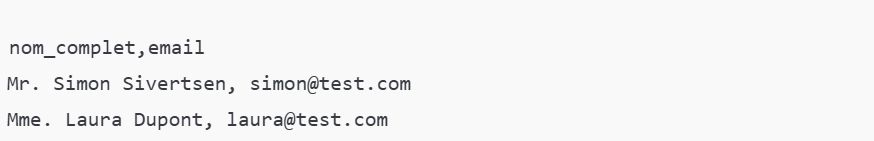

2️⃣Choisir un site web public où il y''a des informations complémentaires (exemple : LinkedIn public profiles, annuaire d’entreprises, site e-commerce).
Mais il faut toujours vérifier les conditions légales (robots.txt, CGU du site).

Écrire un scraper (par ex. avec requests + BeautifulSoup) pour aller chercher automatiquement l’info.
Exemple : récupérer la ville et l’entreprise d’une personne depuis un annuaire public.

3️⃣ Écrire un scraper (par ex. avec requests + BeautifulSoup) pour aller chercher automatiquement l’info.
Exemple : récupérer la ville et l’entreprise d’une personne depuis un annuaire public

In [18]:
# Premier exemple : HTML simulé
from bs4 import BeautifulSoup

html_doc = """
<html>
  <body>
    <span class="city">Paris</span>
    <span class="company">DataCorp</span>
  </body>
</html>
"""

soup = BeautifulSoup(html_doc, "html.parser")

ville = soup.find("span", class_="city").text
entreprise = soup.find("span", class_="company").text

print("=== Exemple 1 : HTML simulé ===")
print("Ville :", ville)
print("Entreprise :", entreprise, "\n")

# Deuxième exemple : Wikipedia
import requests
from bs4 import BeautifulSoup

url = "https://fr.wikipedia.org/wiki/Paris"
headers = {"User-Agent": "Mozilla/5.0"}
r = requests.get(url, headers=headers, timeout=10)
r.raise_for_status()

soup = BeautifulSoup(r.text, "html.parser")
titre = soup.find("h1").get_text(strip=True)
paragraphe = soup.find("p").get_text(strip=True)

print("=== Exemple 2 : Wikipedia ===")
print("Titre :", titre)
print("Premier paragraphe :", paragraphe[:200], "…\n")

# Troisième exemple : Quotes to Scrape
url = "https://quotes.toscrape.com/"
r = requests.get(url, timeout=10)
r.raise_for_status()

soup = BeautifulSoup(r.text, "html.parser")
quote = soup.select_one(".quote .text").get_text(strip=True)
author = soup.select_one(".quote .author").get_text(strip=True)

print("=== Exemple 3 : Quotes to Scrape ===")
print("Citation :", quote)
print("Auteur :", author)


=== Exemple 1 : HTML simulé ===
Ville : Paris
Entreprise : DataCorp 



ModuleNotFoundError: No module named 'requests'

4️⃣ Fusionner ces infos avec ton dataset:
Ton dataset de 2 colonnes (nom_complet, email) devient 4 colonnes (Exp nom_complet, email, ville, entreprise.

**Ce qu'il faut retenir**
Dans un cas réel, le web scraping nous permet d’enrichir un dataset existant.
Par exemple, si on a uniquement le nom et l’email d’un client, on peut scraper un site public pour récupérer son entreprise, sa ville ou son secteur.
Ensuite, on ajoute ces nouvelles colonnes à notre dataset → et ça devient beaucoup plus utile pour le clustering, la segmentation marketing, ou la recommandation.

In [ ]:
import pandas as pd

# Dataset initial
data = {
    "nom_complet": ["Mr. Simon Sivertsen", "Mme. Laura Dupont"],
    "email": ["simon@test.com", "laura@test.com"]
}
df = pd.DataFrame(data)

print("=== Dataset initial ===")
print(df, "\n")

# Supposons qu'on a scrapé ces infos depuis un site externe :
infos_scrapees = {
    "ville": ["Paris", "Lyon"],
    "entreprise": ["DataCorp", "TechSolutions"]
}

# Transformer en DataFrame
df_scraping = pd.DataFrame(infos_scrapees)

print("=== Infos scrapées ===")
print(df_scraping, "\n")

# Fusion par index (car l'ordre correspond aux mêmes personnes)
df_final = pd.concat([df, df_scraping], axis=1)

print("=== Dataset final enrichi ===")
print(df_final)


=== Dataset initial ===
           nom_complet           email
0  Mr. Simon Sivertsen  simon@test.com
1    Mme. Laura Dupont  laura@test.com 

=== Infos scrapées ===
   ville     entreprise
0  Paris       DataCorp
1   Lyon  TechSolutions 

=== Dataset final enrichi ===
           nom_complet           email  ville     entreprise
0  Mr. Simon Sivertsen  simon@test.com  Paris       DataCorp
1    Mme. Laura Dupont  laura@test.com   Lyon  TechSolutions


.
**-->** Grâce au web scraping, on a récupéré des infos supplémentaires (ville, entreprise).
On fusionne les deux tableaux → le dataset final est plus riche, plus exploitable pour le Data Minin

In [ ]:
1+1

2

**Bonnes pratiques pour le web scraping :**

Toujours tester l’URL dans un navigateur avant de coder, pour vérifier que la page existe bien et se charge correctement.

Consulter le fichier robots.txt du site ainsi que les Conditions Générales d’Utilisation (CGU) afin de s’assurer que le scraping est autorisé.

Adapter les sélecteurs CSS (.city, .company, etc.) en fonction de la structure HTML réelle de la page.

Utiliser des en-têtes (headers) comme un User-Agent pour éviter certains blocages.

Ajouter un timeout pour ne pas bloquer le script si la page est trop lente.

Employer raise_for_status() afin d’obtenir immédiatement une erreur claire en cas de problème HTTP (404, 403, etc.)